In [1]:
!cd .. && mkdir build
!cd ../build/ && rm -rf *
!cd ../build && cmake \
  -DPYTHON_EXECUTABLE="$(which python3)" \
  -DCMAKE_BUILD_TYPE=Release ..
!cd ../build && make install

mkdir: build: File exists
-- The C compiler identification is AppleClang 11.0.3.11030032
-- The CXX compiler identification is AppleClang 11.0.3.11030032
-- Check for working C compiler: /Library/Developer/CommandLineTools/usr/bin/cc
-- Check for working C compiler: /Library/Developer/CommandLineTools/usr/bin/cc - works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /Library/Developer/CommandLineTools/usr/bin/c++
-- Check for working CXX compiler: /Library/Developer/CommandLineTools/usr/bin/c++ - works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
Release mode
-- Found PythonInterp: /usr/local/bin/python3 (found version "3.7.7") 
-- Found PythonLibs: /usr/local/opt/python/Frameworks/Python.framework/Versions/3.7/lib/libpython3.7m.dylib
-- pybind11 v2.5

In [2]:
import math 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from mpl_toolkits import mplot3d
from sklearn.linear_model import LinearRegression

In [3]:
# Verifico la correcta instalación. Si no falla el import está OK
!pwd
!python --version
import metnum

/Users/mariano.benzo/Facultad/Metodos/TP3/metnum-tp3/notebooks
Python 2.7.16


## Linear Regression Predict

In [4]:
def linearRegressorPredict(df_train, df_test, cs, cPred):
    x = df_train[cs].values
    y = df_train[cPred].values
    x = x.reshape(len(x), x.shape[1])
    y = y.reshape(len(y), 1)

    linear_regressor = metnum.LinearRegression()
    linear_regressor.fit(x,y)

    x = df_test[cs].values
    x = x.reshape(len(x), x.shape[1])
    
    df_test[cPred] = linear_regressor.predict(x)
    
    df_test = df_test[df_test[cPred] < 0].dropna()


## K-Fold Cross-Validation

In [5]:
def splitTrainSet(x, y, K, i):
    size = int(x.shape[0] * 1/K)
    
    x_train1 = x[:i * size]
    x_train2 = x[(i + 1) * size:]
    x_train = np.concatenate((x_train1, x_train2))
    x_test = x[i * size:(i + 1) * size]
    
    y_train1 = y[:i * size]
    y_train2 = y[(i + 1) * size:]
    y_train = np.concatenate((y_train1, y_train2))
    y_test = y[i * size:(i + 1) * size]
    
    return x_train, y_train, x_test, y_test

In [6]:
from sklearn.linear_model import LinearRegression

def linearRegressionKFoldErrors(df_train, cs, cPred, K):
    
    x = df_train[cs].values
    y = df_train[cPred].values
    x = x.reshape(len(x), x.shape[1])
    y = y.reshape(len(y), 1)

    RMSE = []
    RMSLE = []
    average_error = []
    
    for i in range(0, K):
        x_train, y_train, x_test, y_test = splitTrainSet(x, y, K, i)
                
        linear_regressor = metnum.LinearRegression()

        linear_regressor.fit(x_train, y_train)
        
        y_pred = linear_regressor.predict(x_test)
        
        y_test, y_pred = deleteNegativeElements(y_test, y_pred)
            
        e = linearRegressorRMSE(y_test, y_pred)
        le = linearRegressorRMSLE(y_test, y_pred)
        avg_error = linearRegressorAverageError(y_test, y_pred)
        
        RMSE.append(e)
        RMSLE.append(le)
        average_error.append(avg_error)

    RMSE = np.mean(RMSE)
    RMSLE = np.mean(RMSLE)
    average_error = np.mean(average_error)

    return RMSE, RMSLE, average_error

In [7]:
def deleteNegativeElements(y_test, y_pred):
    negativeIndex = []
    for i in range(0, len(y_pred)):
        if (y_pred[i] < 0 or y_test[i] < 0):
            negativeIndex.append(i)

    y_pred = [i for j, i in enumerate(y_pred) if j not in negativeIndex]
    y_test = [i for j, i in enumerate(y_test) if j not in negativeIndex]
            
    return y_test, y_pred

## RMSE & RMSLE & Average Error

In [8]:
def linearRegressorRMSE(y_test, y_pred):
    n = len(y_test)
    return math.sqrt(sum([(y_test[i] - y_pred[i])**2 for i in range(0, n)]) / n)

In [9]:
def linearRegressorRMSLE(y_test, y_pred):
    n = len(y_test)    
    return math.sqrt(sum([(math.log(y_test[i] + 1) - (math.log(y_pred[i] + 1)))**2 for i in range(0, n)]) / n)

In [10]:
def linearRegressorAverageError(y_test, y_pred):
    n = len(y_test)
    avg = np.mean(y_test)
    avg_error = np.mean([abs(y_test[i] - y_pred[i]) for i in range(0, n)])
    
    return avg_error / avg

## Figures 2D

In [11]:
def linearRegressorFigure2D(df_train, df_test, c1, cPred, name):
    sns.scatterplot(data=df_train, x=c1, y=cPred)
    sns_plot = sns.lineplot(data=df_test, x=c1, y=cPred, color='red')
    sns_plot.figure.savefig('graficos/' + name + '-' + cPred + '-' + c1 + '.png')
    sns_plot

## Experimentacion: Precio casas nuevas

### Metros cubiertos

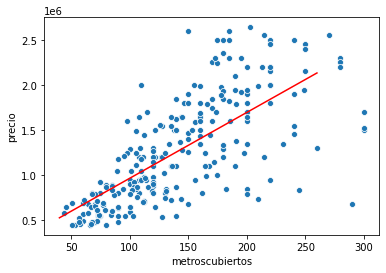

In [12]:
df_train = pd.read_csv('../data/train-new-houses.csv')

n = int(len(df_train)/3)
df_test = df_train[:n]
df_train = df_train[n:]

linearRegressorPredict(df_train, df_test, ['metroscubiertos'], 'precio')
linearRegressorFigure2D(df_train, df_test, 'metroscubiertos', 'precio', 'new-houses-1')

In [13]:
df_train = pd.read_csv('../data/train-new-houses.csv')
K = 5

RMSE, RMSLE, average_error = linearRegressionKFoldErrors(df_train, ['metroscubiertos'], 'precio', K)
print('RMSLE: ', RMSLE)

RMSLE:  0.31030162344173834


### Baños

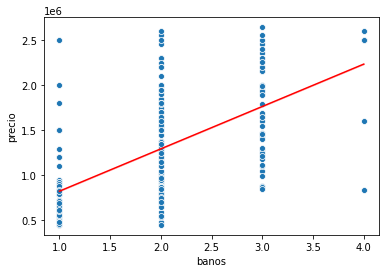

In [14]:
df_train = pd.read_csv('../data/train-new-houses.csv')

n = int(len(df_train)/3)
df_test = df_train[:n]
df_train = df_train[n:]

linearRegressorPredict(df_train, df_test, ['banos'], 'precio')
linearRegressorFigure2D(df_train, df_test, 'banos', 'precio', 'new-houses-2')

In [15]:
df_train = pd.read_csv('../data/train-new-houses.csv')
K = 5

RMSE, RMSLE, average_error = linearRegressionKFoldErrors(df_train, ['banos'], 'precio', K)
print('RMSLE: ', RMSLE)

RMSLE:  0.3853891952601749


### Habitaciones

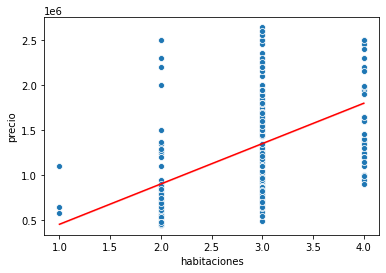

In [16]:
df_train = pd.read_csv('../data/train-new-houses.csv')

n = int(len(df_train)/3)
df_test = df_train[:n]
df_train = df_train[n:]

linearRegressorPredict(df_train, df_test, ['habitaciones'], 'precio')
linearRegressorFigure2D(df_train, df_test, 'habitaciones', 'precio', 'new-houses-3')

In [17]:
df_train = pd.read_csv('../data/train-new-houses.csv')
K = 5

RMSE, RMSLE, average_error = linearRegressionKFoldErrors(df_train, ['habitaciones'], 'precio', K)
print('RMSLE: ', RMSLE)

RMSLE:  0.40473263617230193


### Metros totales

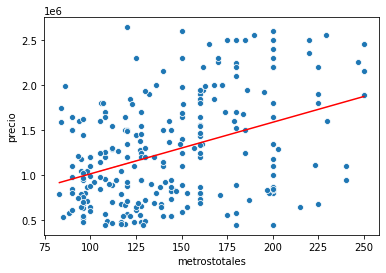

In [18]:
df_train = pd.read_csv('../data/train-new-houses.csv')

n = int(len(df_train)/3)
df_test = df_train[:n]
df_train = df_train[n:]

linearRegressorPredict(df_train, df_test, ['metrostotales'], 'precio')
linearRegressorFigure2D(df_train, df_test, 'metrostotales', 'precio', 'new-houses-4')

In [19]:
df_train = pd.read_csv('../data/train-new-houses.csv')
K = 5

RMSE, RMSLE, average_error = linearRegressionKFoldErrors(df_train, ['metrostotales'], 'precio', K)
print('RMSLE: ', RMSLE)

RMSLE:  0.4615780806916214


### Garages

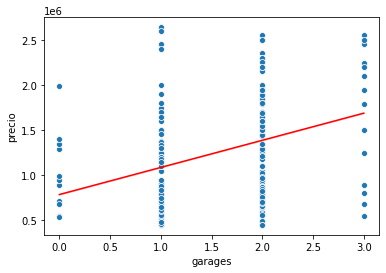

In [20]:
df_train = pd.read_csv('../data/train-new-houses.csv')

n = int(len(df_train)/3)
df_test = df_train[:n]
df_train = df_train[n:]

linearRegressorPredict(df_train, df_test, ['garages'], 'precio')
linearRegressorFigure2D(df_train, df_test, 'garages', 'precio', 'new-houses-5')

In [21]:
df_train = pd.read_csv('../data/train-new-houses.csv')
K = 5

RMSE, RMSLE, average_error = linearRegressionKFoldErrors(df_train, ['garages'], 'precio', K)
print('RMSLE: ', RMSLE)

RMSLE:  0.4662719677734032


### Densidad poblacional

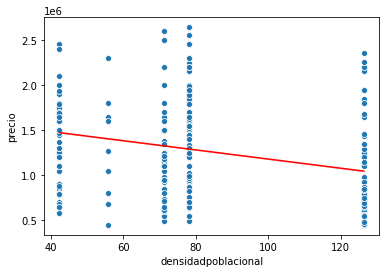

In [22]:
df_train = pd.read_csv('../data/train-new-houses.csv')

n = int(len(df_train)/3)
df_test = df_train[:n]
df_train = df_train[n:]

linearRegressorPredict(df_train, df_test, ['densidadpoblacional'], 'precio')
linearRegressorFigure2D(df_train, df_test, 'densidadpoblacional', 'precio', 'new-houses-6')

In [23]:
df_train = pd.read_csv('../data/train-new-houses.csv')
K = 5

RMSE, RMSLE, average_error = linearRegressionKFoldErrors(df_train, ['densidadpoblacional'], 'precio', K)
print('RMSLE: ', RMSLE)

RMSLE:  0.4782412459931189


### Piscina

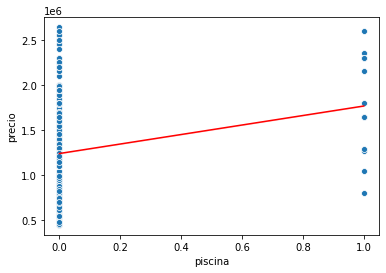

In [24]:
df_train = pd.read_csv('../data/train-new-houses.csv')

n = int(len(df_train)/3)
df_test = df_train[:n]
df_train = df_train[n:]

linearRegressorPredict(df_train, df_test, ['piscina'], 'precio')
linearRegressorFigure2D(df_train, df_test, 'piscina', 'precio', 'new-houses-7')

In [25]:
df_train = pd.read_csv('../data/train-new-houses.csv')
K = 5

RMSE, RMSLE, average_error = linearRegressionKFoldErrors(df_train, ['piscina'], 'precio', K)
print('RMSLE: ', RMSLE)

RMSLE:  0.49143320639451565


### Comodidades

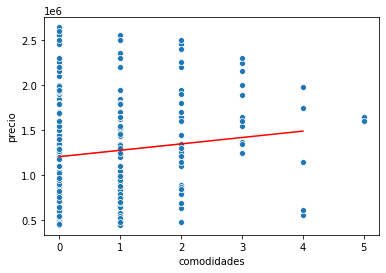

In [26]:
df_train = pd.read_csv('../data/train-new-houses.csv')

n = int(len(df_train)/3)
df_test = df_train[:n]
df_train = df_train[n:]

linearRegressorPredict(df_train, df_test, ['comodidades'], 'precio')
linearRegressorFigure2D(df_train, df_test, 'comodidades', 'precio', 'new-houses-8')

In [27]:
df_train = pd.read_csv('../data/train-new-houses.csv')
K = 5

RMSE, RMSLE, average_error = linearRegressionKFoldErrors(df_train, ['comodidades'], 'precio', K)
print('RMSLE: ', RMSLE)

RMSLE:  0.4919013712411438


### Criminalidad

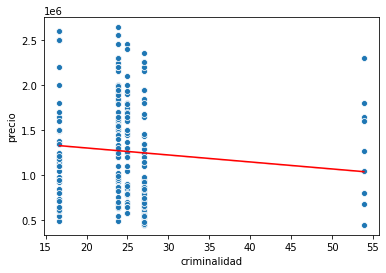

In [28]:
df_train = pd.read_csv('../data/train-new-houses.csv')

n = int(len(df_train)/3)
df_test = df_train[:n]
df_train = df_train[n:]

linearRegressorPredict(df_train, df_test, ['criminalidad'], 'precio')
linearRegressorFigure2D(df_train, df_test, 'criminalidad', 'precio', 'new-houses-9')

In [29]:
df_train = pd.read_csv('../data/train-new-houses.csv')
K = 5

RMSE, RMSLE, average_error = linearRegressionKFoldErrors(df_train, ['criminalidad'], 'precio', K)
print('RMSLE: ', RMSLE)

RMSLE:  0.5001518854944708


### Antigüedad

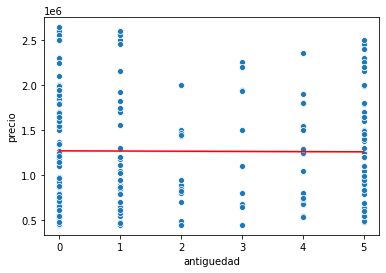

In [30]:
df_train = pd.read_csv('../data/train-new-houses.csv')

n = int(len(df_train)/3)
df_test = df_train[:n]
df_train = df_train[n:]

linearRegressorPredict(df_train, df_test, ['antiguedad'], 'precio')
linearRegressorFigure2D(df_train, df_test, 'antiguedad', 'precio', 'new-houses-10')

In [31]:
df_train = pd.read_csv('../data/train-new-houses.csv')
K = 5

RMSE, RMSLE, average_error = linearRegressionKFoldErrors(df_train, ['antiguedad'], 'precio', K)
print('RMSLE: ', RMSLE)

RMSLE:  0.5008310721006706


### Mejor combinacion

In [33]:
df_train = pd.read_csv('../data/train-new-houses.csv')
K = 5

RMSE, RMSLE, average_error = linearRegressionKFoldErrors(df_train, [], 'precio', K)
print('RMSLE []:\n', RMSLE)
RMSE, RMSLE, average_error = linearRegressionKFoldErrors(df_train, ['metroscubiertos'], 'precio', K)
print('RMSLE [metroscubiertos]:\n', RMSLE)
RMSE, RMSLE, average_error = linearRegressionKFoldErrors(df_train, ['metroscubiertos', 'banos'], 'precio', K)
print('RMSLE [metroscubiertos, banos]:\n', RMSLE)
RMSE, RMSLE, average_error = linearRegressionKFoldErrors(df_train, ['metroscubiertos', 'banos', 'habitaciones'], 'precio', K)
print('RMSLE [metroscubiertos, banos, habitaciones]:\n', RMSLE)
RMSE, RMSLE, average_error = linearRegressionKFoldErrors(df_train, ['metroscubiertos', 'banos', 'habitaciones', 'metrostotales'], 'precio', K)
print('RMSLE [metroscubiertos, banos, habitaciones, metrostotales]:\n', RMSLE)
RMSE, RMSLE, average_error = linearRegressionKFoldErrors(df_train, ['metroscubiertos', 'banos', 'habitaciones', 'metrostotales', 'garages'], 'precio', K)
print('RMSLE [metroscubiertos, banos, habitaciones, metrostotales, garages]:\n', RMSLE)
RMSE, RMSLE, average_error = linearRegressionKFoldErrors(df_train, ['metroscubiertos', 'banos', 'habitaciones', 'metrostotales', 'densidadpoblacional'], 'precio', K)
print('RMSLE [metroscubiertos, banos, habitaciones, metrostotales, densidadpoblacional]:\n', RMSLE)
RMSE, RMSLE, average_error = linearRegressionKFoldErrors(df_train, ['metroscubiertos', 'banos', 'habitaciones', 'metrostotales', 'densidadpoblacional', 'piscina'], 'precio', K)
print('RMSLE [metroscubiertos, banos, habitaciones, metrostotales, densidadpoblacional, piscina]:\n', RMSLE)
RMSE, RMSLE, average_error = linearRegressionKFoldErrors(df_train, ['metroscubiertos', 'banos', 'habitaciones', 'metrostotales', 'densidadpoblacional', 'piscina', 'comodidades'], 'precio', K)
print('RMSLE [metroscubiertos, banos, habitaciones, metrostotales, densidadpoblacional, piscina, comodidades]:\n', RMSLE)
RMSE, RMSLE, average_error = linearRegressionKFoldErrors(df_train, ['metroscubiertos', 'banos', 'habitaciones', 'metrostotales', 'densidadpoblacional', 'piscina', 'criminalidad'], 'precio', K)
print('RMSLE [metroscubiertos, banos, habitaciones, metrostotales, densidadpoblacional, piscina, criminalidad]:\n', RMSLE)
RMSE, RMSLE, average_error = linearRegressionKFoldErrors(df_train, ['metroscubiertos', 'banos', 'habitaciones', 'metrostotales', 'densidadpoblacional', 'piscina', 'antiguedad'], 'precio', K)
print('RMSLE [metroscubiertos, banos, habitaciones, metrostotales, densidadpoblacional, piscina, antiguedad]:\n', RMSLE)

RMSE, RMSLE, average_error = linearRegressionKFoldErrors(df_train, ['metroscubiertos', 'banos', 'habitaciones', 'metrostotales', 'densidadpoblacional', 'piscina', 'antiguedad'], 'precio', K)
print('\nMejor RMSLE [metroscubiertos, banos, habitaciones, metrostotales, densidadpoblacional, piscina, antiguedad]:\n', RMSLE)



RMSLE []:
 0.4984982085520002
RMSLE [metroscubiertos]:
 0.31030162344173834
RMSLE [metroscubiertos, banos]:
 0.30007807706118755
RMSLE [metroscubiertos, banos, habitaciones]:
 0.2998918822188072
RMSLE [metroscubiertos, banos, habitaciones, metrostotales]:
 0.2981562150328322
RMSLE [metroscubiertos, banos, habitaciones, metrostotales, garages]:
 0.29818971732121347
RMSLE [metroscubiertos, banos, habitaciones, metrostotales, densidadpoblacional]:
 0.2911953943991692
RMSLE [metroscubiertos, banos, habitaciones, metrostotales, densidadpoblacional, piscina]:
 0.2883200597651337
RMSLE [metroscubiertos, banos, habitaciones, metrostotales, densidadpoblacional, piscina, comodidades]:
 0.2883960302588655
RMSLE [metroscubiertos, banos, habitaciones, metrostotales, densidadpoblacional, piscina, criminalidad]:
 0.29009010095714816
RMSLE [metroscubiertos, banos, habitaciones, metrostotales, densidadpoblacional, piscina, antiguedad]:
 0.2878957625313122

Mejor RMSLE [metroscubiertos, banos, habitacio

## Experimentacion: Precio casas antiguas

### Metros cubiertos

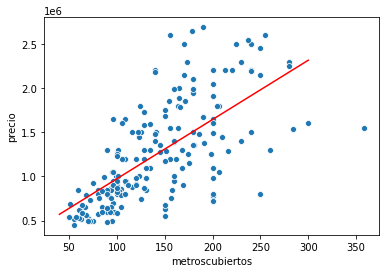

In [34]:
df_train = pd.read_csv('../data/train-old-houses.csv')

n = int(len(df_train)/3)
df_test = df_train[:n]
df_train = df_train[n:]

linearRegressorPredict(df_train, df_test, ['metroscubiertos'], 'precio')
linearRegressorFigure2D(df_train, df_test, 'metroscubiertos', 'precio', 'old-houses-1')

In [35]:
df_train = pd.read_csv('../data/train-old-houses.csv')
K = 5

RMSE, RMSLE, average_error = linearRegressionKFoldErrors(df_train, ['metroscubiertos'], 'precio', K)
print('RMSLE: ', RMSLE)

RMSLE:  0.33911543480298906


### Baños

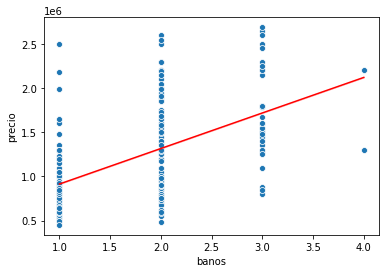

In [36]:
df_train = pd.read_csv('../data/train-old-houses.csv')

n = int(len(df_train)/3)
df_test = df_train[:n]
df_train = df_train[n:]

linearRegressorPredict(df_train, df_test, ['banos'], 'precio')
linearRegressorFigure2D(df_train, df_test, 'banos', 'precio', 'old-houses-2')

In [37]:
df_train = pd.read_csv('../data/train-old-houses.csv')
K = 5

RMSE, RMSLE, average_error = linearRegressionKFoldErrors(df_train, ['banos'], 'precio', K)
print('RMSLE: ', RMSLE)

RMSLE:  0.3975904507674799


### Metros totales

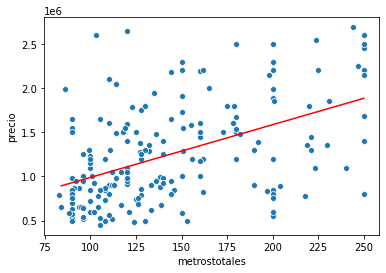

In [38]:
df_train = pd.read_csv('../data/train-old-houses.csv')

n = int(len(df_train)/3)
df_test = df_train[:n]
df_train = df_train[n:]

linearRegressorPredict(df_train, df_test, ['metrostotales'], 'precio')
linearRegressorFigure2D(df_train, df_test, 'metrostotales', 'precio', 'old-houses-3')

In [39]:
df_train = pd.read_csv('../data/train-old-houses.csv')
K = 5

RMSE, RMSLE, average_error = linearRegressionKFoldErrors(df_train, ['metrostotales'], 'precio', K)
print('RMSLE: ', RMSLE)

RMSLE:  0.4182732436958726


### Habitaciones

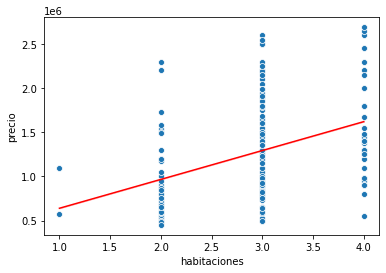

In [40]:
df_train = pd.read_csv('../data/train-old-houses.csv')

n = int(len(df_train)/3)
df_test = df_train[:n]
df_train = df_train[n:]

linearRegressorPredict(df_train, df_test, ['habitaciones'], 'precio')
linearRegressorFigure2D(df_train, df_test, 'habitaciones', 'precio', 'old-houses-4')

In [41]:
df_train = pd.read_csv('../data/train-old-houses.csv')
K = 5

RMSE, RMSLE, average_error = linearRegressionKFoldErrors(df_train, ['habitaciones'], 'precio', K)
print('RMSLE: ', RMSLE)

RMSLE:  0.42260131542102597


### Garages

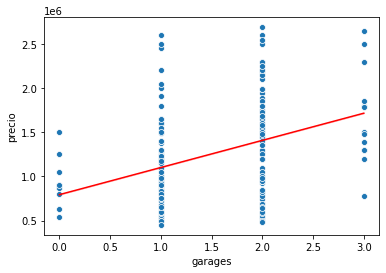

In [42]:
df_train = pd.read_csv('../data/train-old-houses.csv')

n = int(len(df_train)/3)
df_test = df_train[:n]
df_train = df_train[n:]

linearRegressorPredict(df_train, df_test, ['garages'], 'precio')
linearRegressorFigure2D(df_train, df_test, 'garages', 'precio', 'old-houses-5')

In [43]:
df_train = pd.read_csv('../data/train-old-houses.csv')
K = 5

RMSE, RMSLE, average_error = linearRegressionKFoldErrors(df_train, ['garages'], 'precio', K)
print('RMSLE: ', RMSLE)

RMSLE:  0.4424374861662452


### Comodidades

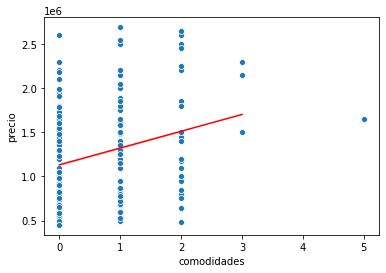

In [44]:
df_train = pd.read_csv('../data/train-old-houses.csv')

n = int(len(df_train)/3)
df_test = df_train[:n]
df_train = df_train[n:]

linearRegressorPredict(df_train, df_test, ['comodidades'], 'precio')
linearRegressorFigure2D(df_train, df_test, 'comodidades', 'precio', 'old-houses-6')

In [45]:
df_train = pd.read_csv('../data/train-old-houses.csv')
K = 5

RMSE, RMSLE, average_error = linearRegressionKFoldErrors(df_train, ['comodidades'], 'precio', K)
print('RMSLE: ', RMSLE)

RMSLE:  0.4603121932411932


### Densidad poblacional

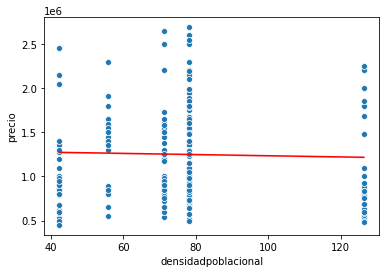

In [46]:
df_train = pd.read_csv('../data/train-old-houses.csv')

n = int(len(df_train)/3)
df_test = df_train[:n]
df_train = df_train[n:]

linearRegressorPredict(df_train, df_test, ['densidadpoblacional'], 'precio')
linearRegressorFigure2D(df_train, df_test, 'densidadpoblacional', 'precio', 'old-houses-7')

In [47]:
df_train = pd.read_csv('../data/train-old-houses.csv')
K = 5

RMSE, RMSLE, average_error = linearRegressionKFoldErrors(df_train, ['densidadpoblacional'], 'precio', K)
print('RMSLE: ', RMSLE)

RMSLE:  0.47123770375502055


### Piscina

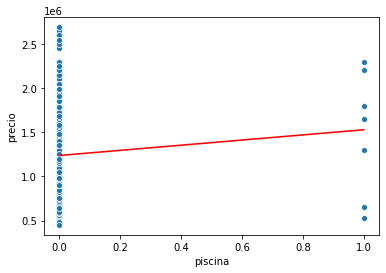

In [48]:
df_train = pd.read_csv('../data/train-old-houses.csv')

n = int(len(df_train)/3)
df_test = df_train[:n]
df_train = df_train[n:]

linearRegressorPredict(df_train, df_test, ['piscina'], 'precio')
linearRegressorFigure2D(df_train, df_test, 'piscina', 'precio', 'old-houses-8')

In [49]:
df_train = pd.read_csv('../data/train-old-houses.csv')
K = 5

RMSE, RMSLE, average_error = linearRegressionKFoldErrors(df_train, ['piscina'], 'precio', K)
print('RMSLE: ', RMSLE)

RMSLE:  0.4724478597852402


### Criminalidad

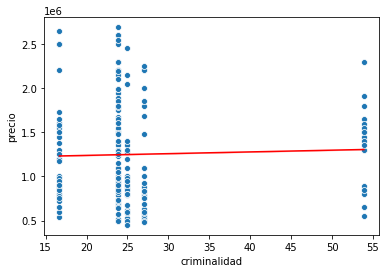

In [50]:
df_train = pd.read_csv('../data/train-old-houses.csv')

n = int(len(df_train)/3)
df_test = df_train[:n]
df_train = df_train[n:]

linearRegressorPredict(df_train, df_test, ['criminalidad'], 'precio')
linearRegressorFigure2D(df_train, df_test, 'criminalidad', 'precio', 'old-houses-9')

In [51]:
df_train = pd.read_csv('../data/train-old-houses.csv')
K = 5

RMSE, RMSLE, average_error = linearRegressionKFoldErrors(df_train, ['criminalidad'], 'precio', K)
print('RMSLE: ', RMSLE)

RMSLE:  0.4734975253092914


### Antigüedad

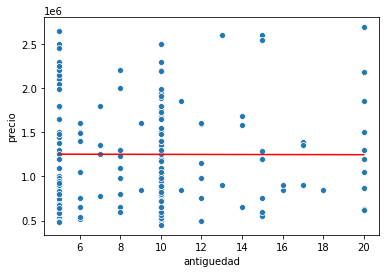

In [52]:
df_train = pd.read_csv('../data/train-old-houses.csv')

n = int(len(df_train)/3)
df_test = df_train[:n]
df_train = df_train[n:]

linearRegressorPredict(df_train, df_test, ['antiguedad'], 'precio')
linearRegressorFigure2D(df_train, df_test, 'antiguedad', 'precio', 'old-houses-10')

In [53]:
df_train = pd.read_csv('../data/train-old-houses.csv')
K = 5

RMSE, RMSLE, average_error = linearRegressionKFoldErrors(df_train, ['antiguedad'], 'precio', K)
print('RMSLE: ', RMSLE)

RMSLE:  0.474963032089785


### Mejor combinacion

In [54]:
df_train = pd.read_csv('../data/train-old-houses.csv')
K = 5

RMSE, RMSLE, average_error = linearRegressionKFoldErrors(df_train, [], 'precio', K)
print('RMSLE []:\n', RMSLE)
RMSE, RMSLE, average_error = linearRegressionKFoldErrors(df_train, ['metroscubiertos'], 'precio', K)
print('RMSLE [metroscubiertos]:\n', RMSLE)
RMSE, RMSLE, average_error = linearRegressionKFoldErrors(df_train, ['metroscubiertos', 'banos'], 'precio', K)
print('RMSLE [metroscubiertos, banos]:\n', RMSLE)
RMSE, RMSLE, average_error = linearRegressionKFoldErrors(df_train, ['metroscubiertos', 'banos', 'metrostotales'], 'precio', K)
print('RMSLE [metroscubiertos, banos, metrostotales]:\n', RMSLE)
RMSE, RMSLE, average_error = linearRegressionKFoldErrors(df_train, ['metroscubiertos', 'banos', 'metrostotales', 'habitaciones'], 'precio', K)
print('RMSLE [metroscubiertos, banos, metrostotales, habitaciones]:\n', RMSLE)
RMSE, RMSLE, average_error = linearRegressionKFoldErrors(df_train, ['metroscubiertos', 'banos', 'metrostotales', 'garages'], 'precio', K)
print('RMSLE [metroscubiertos, banos, metrostotales, garages]:\n', RMSLE)
RMSE, RMSLE, average_error = linearRegressionKFoldErrors(df_train, ['metroscubiertos', 'banos', 'metrostotales', 'garages', 'comodidades'], 'precio', K)
print('RMSLE [metroscubiertos, banos, metrostotales, garages, comodidades]:\n', RMSLE)
RMSE, RMSLE, average_error = linearRegressionKFoldErrors(df_train, ['metroscubiertos', 'banos', 'metrostotales', 'garages', 'comodidades', 'densidadpoblacional'], 'precio', K)
print('RMSLE [metroscubiertos, banos, metrostotales, garages, comodidades, densidadpoblacional]:\n', RMSLE)
RMSE, RMSLE, average_error = linearRegressionKFoldErrors(df_train, ['metroscubiertos', 'banos', 'metrostotales', 'garages', 'comodidades', 'densidadpoblacional', 'piscina'], 'precio', K)
print('RMSLE [metroscubiertos, banos, metrostotales, garages, comodidades, densidadpoblacional, piscina]:\n', RMSLE)
RMSE, RMSLE, average_error = linearRegressionKFoldErrors(df_train, ['metroscubiertos', 'banos', 'metrostotales', 'garages', 'comodidades', 'densidadpoblacional', 'piscina', 'criminalidad'], 'precio', K)
print('RMSLE [metroscubiertos, banos, metrostotales, garages, comodidades, densidadpoblacional, piscina, criminalidad]:\n', RMSLE)
RMSE, RMSLE, average_error = linearRegressionKFoldErrors(df_train, ['metroscubiertos', 'banos', 'metrostotales', 'garages', 'comodidades', 'densidadpoblacional', 'piscina', 'criminalidad', 'antiguedad'], 'precio', K)
print('RMSLE [metroscubiertos, banos, metrostotales, garages, comodidades, densidadpoblacional, piscina, criminalidad, antiguedad]:\n', RMSLE)


RMSE, RMSLE, average_error = linearRegressionKFoldErrors(df_train, ['metroscubiertos', 'banos', 'metrostotales', 'garages', 'comodidades', 'densidadpoblacional', 'piscina', 'criminalidad'], 'precio', K)
print('\nMejor RMSLE [metroscubiertos, banos, metrostotales, garages, comodidades, densidadpoblacional, piscina, criminalidad]\n', RMSLE)


RMSLE []:
 0.4734669944096364
RMSLE [metroscubiertos]:
 0.33911543480298906
RMSLE [metroscubiertos, banos]:
 0.32754413016816675
RMSLE [metroscubiertos, banos, metrostotales]:
 0.32249071195996104
RMSLE [metroscubiertos, banos, metrostotales, habitaciones]:
 0.32259446913207035
RMSLE [metroscubiertos, banos, metrostotales, garages]:
 0.319353839406591
RMSLE [metroscubiertos, banos, metrostotales, garages, comodidades]:
 0.3185808694987807
RMSLE [metroscubiertos, banos, metrostotales, garages, comodidades, densidadpoblacional]:
 0.3155581801069046
RMSLE [metroscubiertos, banos, metrostotales, garages, comodidades, densidadpoblacional, piscina]:
 0.31519729009848707
RMSLE [metroscubiertos, banos, metrostotales, garages, comodidades, densidadpoblacional, piscina, criminalidad]:
 0.3118100816647499
RMSLE [metroscubiertos, banos, metrostotales, garages, comodidades, densidadpoblacional, piscina, criminalidad, antiguedad]:
 0.31201186235875367

Mejor RMSLE [metroscubiertos, banos, metrostota

## Experimentacion: Cantidad de baños

### Precio

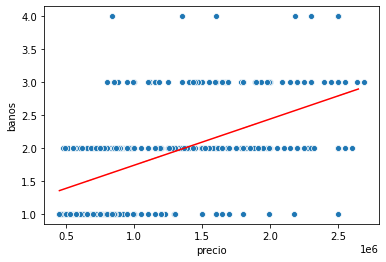

In [55]:
df_train = pd.read_csv('../data/train-all-houses.csv')

n = int(len(df_train)/3)
df_test = df_train[:n]
df_train = df_train[n:]

linearRegressorPredict(df_train, df_test, ['precio'], 'banos')
linearRegressorFigure2D(df_train, df_test, 'precio', 'banos', 'all-houses-1')

In [56]:
df_train = pd.read_csv('../data/train-all-houses.csv')
K = 5

RMSE, RMSLE, average_error = linearRegressionKFoldErrors(df_train, ['precio'], 'banos', K)
print('RMSE: ', RMSE)

RMSE:  0.6218585416414305


### Metros cubiertos

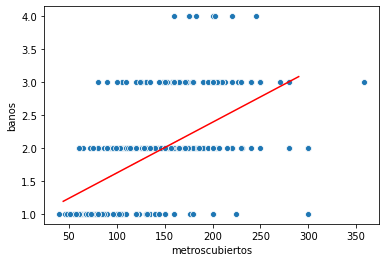

In [57]:
df_train = pd.read_csv('../data/train-all-houses.csv')

n = int(len(df_train)/3)
df_test = df_train[:n]
df_train = df_train[n:]

linearRegressorPredict(df_train, df_test, ['metroscubiertos'], 'banos')
linearRegressorFigure2D(df_train, df_test, 'metroscubiertos', 'banos', 'all-houses-2')

In [58]:
df_train = pd.read_csv('../data/train-all-houses.csv')
K = 5

RMSE, RMSLE, average_error = linearRegressionKFoldErrors(df_train, ['metroscubiertos'], 'banos', K)
print('RMSE: ', RMSE)

RMSE:  0.6225644745045773


### Habitaciones

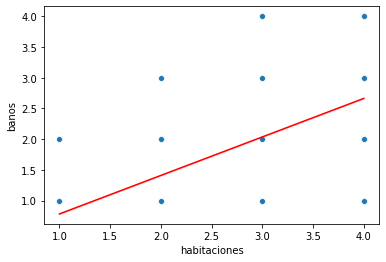

In [59]:
df_train = pd.read_csv('../data/train-all-houses.csv')

n = int(len(df_train)/3)
df_test = df_train[:n]
df_train = df_train[n:]

linearRegressorPredict(df_train, df_test, ['habitaciones'], 'banos')
linearRegressorFigure2D(df_train, df_test, 'habitaciones', 'banos', 'all-houses-3')

In [60]:
df_train = pd.read_csv('../data/train-all-houses.csv')
K = 5

RMSE, RMSLE, average_error = linearRegressionKFoldErrors(df_train, ['habitaciones'], 'banos', K)
print('RMSE: ', RMSE)

RMSE:  0.6401796505932917


### Metros totales

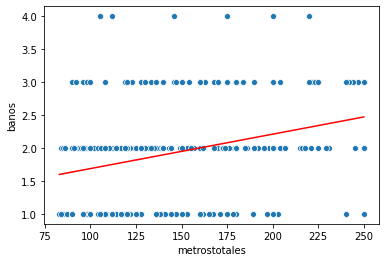

In [61]:
df_train = pd.read_csv('../data/train-all-houses.csv')

n = int(len(df_train)/3)
df_test = df_train[:n]
df_train = df_train[n:]

linearRegressorPredict(df_train, df_test, ['metrostotales'], 'banos')
linearRegressorFigure2D(df_train, df_test, 'metrostotales', 'banos', 'all-houses-4')

In [62]:
df_train = pd.read_csv('../data/train-all-houses.csv')
K = 5

RMSE, RMSLE, average_error = linearRegressionKFoldErrors(df_train, ['metrostotales'], 'banos', K)
print('RMSE: ', RMSE)

RMSE:  0.716736880684398


### Antigüedad

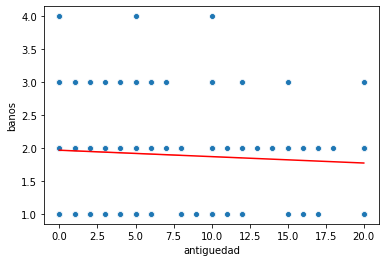

In [63]:
df_train = pd.read_csv('../data/train-all-houses.csv')

n = int(len(df_train)/3)
df_test = df_train[:n]
df_train = df_train[n:]

linearRegressorPredict(df_train, df_test, ['antiguedad'], 'banos')
linearRegressorFigure2D(df_train, df_test, 'antiguedad', 'banos', 'all-houses-5')

In [64]:
df_train = pd.read_csv('../data/train-all-houses.csv')
K = 5

RMSE, RMSLE, average_error = linearRegressionKFoldErrors(df_train, ['antiguedad'], 'banos', K)
print('RMSE: ', RMSE)

RMSE:  0.7503240174569589


### Mejor combinacion

In [65]:
df_train = pd.read_csv('../data/train-all-houses.csv')
K = 5

RMSE, RMSLE, average_error = linearRegressionKFoldErrors(df_train, [], 'banos', K)
print('RMSE []:\n', RMSE)
RMSE, RMSLE, average_error = linearRegressionKFoldErrors(df_train, ['precio'], 'banos', K)
print('RMSE [precio]:\n', RMSE)
RMSE, RMSLE, average_error = linearRegressionKFoldErrors(df_train, ['precio', 'metroscubiertos'], 'banos', K)
print('RMSE [precio, metroscubiertos]:\n', RMSE)
RMSE, RMSLE, average_error = linearRegressionKFoldErrors(df_train, ['precio', 'metroscubiertos', 'habitaciones'], 'banos', K)
print('RMSE [precio, metroscubiertos, habitaciones]:\n', RMSE)
RMSE, RMSLE, average_error = linearRegressionKFoldErrors(df_train, ['precio', 'metroscubiertos', 'habitaciones', 'metrostotales'], 'banos', K)
print('RMSE [precio, metroscubiertos, habitaciones, metrostotales]:\n', RMSE)
RMSE, RMSLE, average_error = linearRegressionKFoldErrors(df_train, ['precio', 'metroscubiertos', 'habitaciones', 'antiguedad'], 'banos', K)
print('RMSE [precio, metroscubiertos, habitaciones, antiguedad]:\n', RMSE)


RMSE, RMSLE, average_error = linearRegressionKFoldErrors(df_train, ['metroscubiertos', 'precio', 'habitaciones', 'antiguedad'], 'banos', K)
print('\nMejor RMSE [precio, metroscubiertos, habitaciones, antiguedad]\n', RMSE)



RMSE []:
 0.7498878462853267
RMSE [precio]:
 0.6218585416414305
RMSE [precio, metroscubiertos]:
 0.5960989684720504
RMSE [precio, metroscubiertos, habitaciones]:
 0.5721860292790135
RMSE [precio, metroscubiertos, habitaciones, metrostotales]:
 0.5736682204814715
RMSE [precio, metroscubiertos, habitaciones, antiguedad]:
 0.56769964334048

Mejor RMSE [precio, metroscubiertos, habitaciones, antiguedad]
 0.56769964334048
